<a href="https://colab.research.google.com/github/ganguli-lab/grid-pattern-formation/blob/master/square_grid_cells.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
sns.set(style='ticks',font_scale=1.2)

from tqdm import tqdm_notebook as tqdm

!pip install tensorflow==1.14.0
import tensorflow as tf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

# Generate simulated trajectories

In [2]:
def min_dist_angle(position, direction, box_size):
    x, y = position
    dists = [box_size-x, box_size-y, box_size+x, box_size+y]
    d_wall = np.min(dists)
    angles = np.arange(4)*np.pi/2
    theta = angles[np.argmin(dists)]
    a_wall = direction - theta
    a_wall = (a_wall + np.pi) % (2*np.pi) - np.pi
    return d_wall, a_wall

In [3]:
# random velocity samples
def generate_trajectory():
    v = np.random.rayleigh(b);
    #initialize variables
    position = np.zeros([samples+1, 2])
    head_dir = np.zeros(samples+1)
    turning = np.zeros(samples+1, dtype='bool')
    
    position[0] = np.random.uniform(-box_size, box_size, 2)
    head_dir[0] = np.random.uniform(0,2*np.pi)
    ego_v = np.zeros(samples+1)
    
    #generate sequence of random boosts and turns
    random_turn = np.random.normal(mu, sigma, samples+1)
    random_vel = np.random.rayleigh(b, samples+1)
    
    for i in range(1,samples+1):
        #If in border region, turn and slow down
        d_wall, a_wall = min_dist_angle(position[i-1], head_dir[i-1] % (2*np.pi), box_size)
        if d_wall < border_region and np.abs(a_wall) < np.pi/2:
            turning[i-1] = 1 
            turn_angle = np.sign(a_wall)* (np.pi/2 - np.abs(a_wall)) + dt*random_turn[i]
            v = 0.25*v
        else:
            v = random_vel[i]
            turn_angle = dt*random_turn[i]
        #Take a step
        ego_v[i-1] = v*dt
        position[i] = position[i-1] + ego_v[i-1]*np.asarray([np.cos(head_dir[i-1]), np.sin(head_dir[i-1])])
        #Rotate head direction
        head_dir[i] = (head_dir[i-1] + turn_angle) 
    ang_velocity = np.diff(head_dir)
    theta_x, theta_y = np.cos(ang_velocity), np.sin(ang_velocity)
    head_dir = (head_dir +np.pi) % (2*np.pi) - np.pi #Constrain head_dir to interval (-pi, pi)
    return position[:-1,0], position[:-1, 1], head_dir[:-1], ego_v[:-1], theta_x, theta_y, turning[:-1]

In [4]:
# Simulated trajectory params

dt = 0.02 #time step increment (seconds)
samples = int(2/dt) + 1 #number of time points
box_size = 2.2 / 2 #meters
border_region = 0.03 #meters

turn_angle = 0

mu = 0
sigma = 5.76 * 2     #stdev rotation velocity (rads/sec)
b = 0.13 * 2 * np.pi #forward velocity rayleigh dist scale (m/sec)

Text(0.5, 1.0, 'Simulated trajectories')

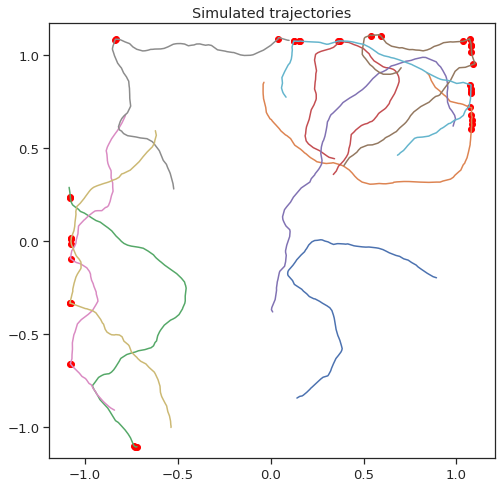

In [5]:
# Plot sample trajectories
plt.figure(figsize=(8,8))
for i in range(10):
    sample_traj = generate_trajectory()
    x = sample_traj[0]
    y = sample_traj[1]
    turning = sample_traj[-1]
    plt.plot(x, y)
    plt.scatter(x[turning], y[turning], c='red')
    
plt.axis("equal")    
t = np.linspace(-np.pi, np.pi, 100)
plt.title('Simulated trajectories')

In [6]:
# Generate trajectories and save to a .tfrecord file

root = ''
data_dir = root + 'simulated_trajs_100_step/'
if not os.path.isdir(data_dir):
  os.mkdir(data_dir)

def _floats_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

num_files = 100
num_trajectories = 100
for i in tqdm(range(num_files)):
    root = ''
    filename = root + 'simulated_trajs_100_step/' + str(i) + '.tfrecord'
    with tf.python_io.TFRecordWriter(filename) as writer:
        for j in range(num_trajectories):
            traj = np.asarray(generate_trajectory())
#             traj = traj[:,::10] # Decimate to approximately match deepmind

            feature = {
                'init_x': _floats_feature([traj[0][0]]),
                'init_y': _floats_feature([traj[1][0]]),
                'init_hd': _floats_feature([traj[2][0]]),
                'ego_v': _floats_feature(traj[3][:-1]),
                'theta_x': _floats_feature(traj[4][:-1]),
                'theta_y': _floats_feature(traj[5][:-1]),
                'target_x': _floats_feature(traj[0][1:]),
                'target_y': _floats_feature(traj[1][1:]),
                'target_hd': _floats_feature(traj[2][1:])
            }

            example = tf.train.Example(features=tf.train.Features(feature=feature))
            writer.write(example.SerializeToString())



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


  0%|          | 0/100 [00:00<?, ?it/s]

# Model

In [7]:
# Model (adapted from https://github.com/deepmind/grid-cells)

class Model(object):
    def __init__(self, flags):
      with tf.variable_scope("model"):
        
          data_manager = DataManager(flags)
          batch = data_manager.get_batch()
          init_x, init_y, init_hd, ego_v, theta_x,  \
            theta_y, target_x, target_y, target_hd = batch
            
          self.inputs = tf.stack([ego_v, theta_x, theta_y], axis=-1)
          init_pos = tf.concat([init_x, init_y], axis=-1)
          self.target_pos = tf.stack([target_x, target_y], axis=-1)
          self.target_hd = tf.expand_dims(target_hd, axis=-1)
            
          print('INIT POS SHAPE = ' + str(init_pos))
          
            
          place_cell_ensembles = get_place_cell_ensembles(
              env_size=2.2,
              neurons_seed=8341,
              targets_type='softmax',
              lstm_init_type='softmax',
              n_pc=[flags.num_place_cells],
              pc_scale=[flags.place_cell_rf])

          head_direction_ensembles = get_head_direction_ensembles(
              neurons_seed=8341,
              targets_type='softmax',
              lstm_init_type='softmax',
              n_hdc=[flags.num_hd_cells],
              hdc_concentration=[flags.hd_cell_rf])
            
          initial_conds = encode_initial_conditions(
              init_pos, init_hd, place_cell_ensembles, head_direction_ensembles)
          self.place_init, self.hd_init = initial_conds


          ensembles_targets = encode_targets(
              self.target_pos, self.target_hd, place_cell_ensembles, head_direction_ensembles)
          self.place_outputs, self.hd_outputs = ensembles_targets
            

          # Drop out probability
          self.keep_prob = tf.constant(flags.keep_prob, dtype=tf.float32)
          
          self.cell = tf.nn.rnn_cell.LSTMCell(128,
                                              state_is_tuple=True)

          # init cell
          self.l0 = tf.layers.dense(self.place_init, 128, use_bias=False) + \
               tf.layers.dense(self.hd_init, 128, use_bias=False)    #turn off biases?
          # init hidden
          self.m0 = tf.layers.dense(self.place_init, 128, use_bias=False) + \
               tf.layers.dense(self.hd_init, 128, use_bias=False)   #turn off biases?
          
          self.initial_state = tf.nn.rnn_cell.LSTMStateTuple(self.l0, self.m0)
          
          self.rnn_output, self.rnn_state = tf.nn.dynamic_rnn(cell=self.cell,
                                                    inputs=self.inputs,
                                                    initial_state=self.initial_state,
                                                    dtype=tf.float32,
                                                    time_major=False)
          
          rnn_output = tf.reshape(self.rnn_output, shape=[-1, 128])

          self.g = tf.layers.dense(rnn_output, 512, use_bias=True)

          g_dropout = tf.nn.dropout(self.g, self.keep_prob)
          
          with tf.variable_scope("outputs"):
              place_logits = tf.layers.dense(g_dropout, flags.num_place_cells, use_bias=True)
              hd_logits    = tf.layers.dense(g_dropout, flags.num_hd_cells, use_bias=True)
              
              place_outputs_reshaped = tf.reshape(self.place_outputs,
                                                  shape=[-1, flags.num_place_cells])
              hd_outputs_reshaped = tf.reshape(self.hd_outputs,
                                               shape=[-1, flags.num_hd_cells])

              self.place_loss = tf.reduce_mean(
                  tf.nn.softmax_cross_entropy_with_logits_v2(labels=place_outputs_reshaped,
                                                          logits=place_logits))
              self.hd_loss = tf.reduce_mean(
                  tf.nn.softmax_cross_entropy_with_logits_v2(labels=hd_outputs_reshaped,
                                                          logits=hd_logits))
              
              self.hd_outputs_result = tf.nn.softmax(hd_logits)
              self.place_outputs_result = tf.nn.softmax(place_logits)
              
              self.hd_accuracy = tf.reduce_mean(tf.metrics.accuracy(labels=tf.argmax(hd_outputs_reshaped,-1),
                                                     predictions=tf.argmax(hd_logits,-1)))
              self.place_accuracy = tf.reduce_mean(tf.metrics.accuracy(labels=tf.argmax(place_outputs_reshaped,-1),
                                                     predictions=tf.argmax(place_logits,-1)))
              



In [8]:
class DataManager(object):
    
    def __init__(self, flags):
        self.flags = flags
        root = ''
        basepath = flags.dataset
        base = os.path.join(root, basepath)
        
        self.filenames = []
        self.num_files = 0
        for file in os.listdir(base):
            if file.endswith('tfrecord'):
                self.filenames.append(os.path.join(root, basepath, file))
                self.num_files += 1
        self.num_traj_per_file = 100

        
    def parser(self, record):
        """Instantiates the ops used to read and parse the data into tensors."""
        feature_map = {
            'init_x':
                tf.FixedLenFeature(
                    shape=[1],
                    dtype=tf.float32),
            'init_y':
                tf.FixedLenFeature(
                    shape=[1],
                    dtype=tf.float32),
            'init_hd':
                tf.FixedLenFeature(
                    shape=[1],
                    dtype=tf.float32),
            'ego_v':
                tf.FixedLenFeature(
                    shape=[self.flags.sequence_length],
                    dtype=tf.float32),
            'theta_x':
                tf.FixedLenFeature(
                    shape=[self.flags.sequence_length],
                    dtype=tf.float32),
            'theta_y':
                tf.FixedLenFeature(
                    shape=[self.flags.sequence_length],
                    dtype=tf.float32),
            'target_x':
                tf.FixedLenFeature(
                    shape=[self.flags.sequence_length],
                    dtype=tf.float32),
            'target_y':
                tf.FixedLenFeature(
                    shape=[self.flags.sequence_length],
                    dtype=tf.float32),
            'target_hd':
                tf.FixedLenFeature(
                    shape=[self.flags.sequence_length],
                    dtype=tf.float32),
        }
        example = tf.parse_single_example(record, feature_map)
        batch = [
            example['init_x'],
            example['init_y'],
            example['init_hd'],
            example['ego_v'],
            example['theta_x'],
            example['theta_y'],
            example['target_x'],
            example['target_y'],
            example['target_hd']
        ]
        return batch


    def get_batch(self):

        # Define dataset
        dataset = tf.data.TFRecordDataset(self.filenames)
        dataset = dataset.map(self.parser)
        num_traj = self.num_files * self.num_traj_per_file
        dataset = dataset.shuffle(buffer_size=num_traj)
        dataset = dataset.batch(self.flags.batch_size)
        num_epochs = self.flags.steps // self.flags.batch_size
        dataset = dataset.repeat(num_epochs)

        iterator = dataset.make_one_shot_iterator()

        batch = iterator.get_next()

        return batch

In [9]:
class Trainer(object):
    def __init__(self, model, flags):
        self.model = model
        
        self._prepare_optimizer(flags)
        self._prepare_summary()
      
    def _prepare_optimizer(self, flags):
        with tf.variable_scope("opt"):
            output_vars = tf.trainable_variables("model/outputs")
            # Apply L2 regularization to output linear layers
            l2_reg_loss = tf.add_n([ tf.nn.l2_loss(v) for v in output_vars
                                     if 'bias' not in v.name ]) * flags.l2_reg
            
            
            # Add grid-to-place weight histogram:
            for v in output_vars:
                if 'bias' not in v.name:
                    tf.summary.histogram(v.name, v)

            optimizer = tf.train.AdamOptimizer(
                learning_rate=flags.learning_rate,
            )
            
            total_loss = self.model.place_loss + \
                         self.model.hd_loss + \
                         l2_reg_loss 

            # Apply gradient clipping
            gvs = optimizer.compute_gradients(total_loss)
            gradient_clipping = flags.gradient_clipping

            clipped_gvs = []
            for grad, var in gvs:
                if "model/outputs" in var.name:
                    gv = (tf.clip_by_value(grad,
                                           -flags.gradient_clipping,
                                           flags.gradient_clipping), var)
                else:
                    gv = (grad, var)
                clipped_gvs.append(gv)
            self.train_op = optimizer.apply_gradients(clipped_gvs)

    def _prepare_summary(self):
        with tf.name_scope("logs"):
            tf.summary.scalar("place_loss", self.model.place_loss)
            tf.summary.scalar("hd_loss",    self.model.hd_loss)
            tf.summary.scalar("place_accuracy", self.model.place_accuracy)
            tf.summary.scalar("hd_accuracy", self.model.hd_accuracy)
        self.summary_op = tf.summary.merge_all()

    def train(self, sess, summary_writer, test_summary_writer, step, flags):
        
        _, summary_str = sess.run([self.train_op, self.summary_op])
        
        if step % 10 == 0:
            summary_writer.add_summary(summary_str, step)

            test_summary_str = sess.run(self.summary_op)

            test_summary_writer.add_summary(test_summary_str, step)

In [10]:
# Ensembles (adapted from https://github.com/deepmind/grid-cells)

def one_hot_max(x, axis=-1):
  """Compute one-hot vectors setting to one the index with the maximum value."""
  return tf.one_hot(tf.argmax(x, axis=axis),
                    depth=x.get_shape()[-1],
                    dtype=x.dtype)


def softmax(x, axis=-1):
  """Compute softmax values for each sets of scores in x."""
  return tf.nn.softmax(x, dim=axis)


def softmax_sample(x):
  """Sample the categorical distribution from logits and sample it."""
  dist = tf.contrib.distributions.OneHotCategorical(logits=x, dtype=tf.float32)
  return dist.sample()


class CellEnsemble(object):
  """Abstract parent class for place and head direction cell ensembles."""

  def __init__(self, n_cells, soft_targets, soft_init):
    self.n_cells = n_cells
    if soft_targets not in ["softmax", "voronoi", "sample", "normalized"]:
      raise ValueError
    else:
      self.soft_targets = soft_targets
    # Provide initialization of LSTM in the same way as targets if not specified
    # i.e one-hot if targets are Voronoi
    if soft_init is None:
      self.soft_init = soft_targets
    else:
      if soft_init not in [
          "softmax", "voronoi", "sample", "normalized", "zeros"
      ]:
        raise ValueError
      else:
        self.soft_init = soft_init

  def get_targets(self, x):
    """Type of target."""

    if self.soft_targets == "normalized":
      targets = tf.exp(self.unnor_logpdf(x))
    elif self.soft_targets == "softmax":
      lp = self.log_posterior(x)
      targets = softmax(lp)
    elif self.soft_targets == "sample":
      lp = self.log_posterior(x)
      targets = softmax_sample(lp)
    elif self.soft_targets == "voronoi":
      lp = self.log_posterior(x)
      targets = one_hot_max(lp)
    return targets

  def get_init(self, x):
    """Type of initialisation."""

    if self.soft_init == "normalized":
      init = tf.exp(self.unnor_logpdf(x))
    elif self.soft_init == "softmax":
      lp = self.log_posterior(x)
      init = softmax(lp)
    elif self.soft_init == "sample":
      lp = self.log_posterior(x)
      init = softmax_sample(lp)
    elif self.soft_init == "voronoi":
      lp = self.log_posterior(x)
      init = one_hot_max(lp)
    elif self.soft_init == "zeros":
      init = tf.zeros_like(self.unnor_logpdf(x))
    return init

  def loss(self, predictions, targets):
    """Loss."""

    if self.soft_targets == "normalized":
      smoothing = 1e-2
      loss = tf.nn.sigmoid_cross_entropy_with_logits(
          labels=(1. - smoothing) * targets + smoothing * 0.5,
          logits=predictions,
          name="ensemble_loss")
      loss = tf.reduce_mean(loss, axis=-1)
    else:
      loss = tf.nn.softmax_cross_entropy_with_logits(
          labels=targets,
          logits=predictions,
          name="ensemble_loss")
    return loss

  def log_posterior(self, x):
    logp = self.unnor_logpdf(x)
    log_posteriors = logp - tf.reduce_logsumexp(logp, axis=2, keep_dims=True)
    return log_posteriors


class PlaceCellEnsemble(CellEnsemble):
  """Calculates the dist over place cells given an absolute position."""

  def __init__(self, n_cells, stdev=0.35, pos_min=-5, pos_max=5, seed=None,
               soft_targets=None, soft_init=None):
    super(PlaceCellEnsemble, self).__init__(n_cells, soft_targets, soft_init)
    # Create a random MoG with fixed cov over the position (Nx2)
    rs = np.random.RandomState(seed)
    self.means = rs.uniform(pos_min, pos_max, size=(self.n_cells, 2))
    self.variances = np.ones_like(self.means) * stdev**2

  def unnor_logpdf(self, trajs):
    # Output the probability of each component at each point (BxTxN)
    diff = trajs[:, :, tf.newaxis, :] - self.means[np.newaxis, np.newaxis, ...]
    unnor_logp = -0.5 * tf.reduce_sum((diff**2)/ self.variances, axis=-1)
    return unnor_logp


class HeadDirectionCellEnsemble(CellEnsemble):
  """Calculates the dist over HD cells given an absolute angle."""

  def __init__(self, n_cells, concentration=20, seed=None,
               soft_targets=None, soft_init=None):
    super(HeadDirectionCellEnsemble, self).__init__(n_cells,
                                                    soft_targets,
                                                    soft_init)
    # Create a random Von Mises with fixed cov over the position
    rs = np.random.RandomState(seed)
    self.means = rs.uniform(-np.pi, np.pi, (n_cells))
    self.kappa = np.ones_like(self.means) * concentration

  def unnor_logpdf(self, x):
    return self.kappa * tf.cos(x - self.means[np.newaxis, np.newaxis, :])


In [11]:
def load_checkpoints(sess):
    saver = tf.train.Saver(max_to_keep=2)
    checkpoint_dir = flags.save_dir + "/checkpoints"
    
    checkpoint = tf.train.get_checkpoint_state(checkpoint_dir)
    if checkpoint and checkpoint.model_checkpoint_path:
        saver.restore(sess, checkpoint.model_checkpoint_path)
        tokens = checkpoint.model_checkpoint_path.split("-")
        step = int(tokens[1])
        print("Loaded checkpoint: {0}, step={1}".format(checkpoint.model_checkpoint_path, step))
        return saver, step+1
    else:
        print("Could not find old checkpoint")
        if not os.path.exists(checkpoint_dir):
            os.mkdir(checkpoint_dir)
        return saver, 0


def save_checkponts(sess, saver, global_step):
    checkpoint_dir = flags.save_dir + "/checkpoints"
    saver.save(sess, checkpoint_dir + '/' + 'checkpoint', global_step=global_step)
    print("Checkpoint saved")


def train(sess, trainer, saver, summary_writer, test_summary_writer, start_step):
    for i in range(start_step, flags.steps):
        trainer.train(sess, summary_writer, test_summary_writer, step=i, flags=flags)
        
        if i % flags.save_interval == flags.save_interval-1:
            save_checkponts(sess, saver, i)

In [12]:
# Utils
def get_place_cell_ensembles(
    env_size, neurons_seed, targets_type, lstm_init_type, n_pc, pc_scale):
  """Create the ensembles for the Place cells."""
  place_cell_ensembles = [
      PlaceCellEnsemble(
          n,
          stdev=s,
          pos_min=-env_size / 2.0,
          pos_max=env_size / 2.0,
          seed=neurons_seed,
          soft_targets=targets_type,
          soft_init=lstm_init_type)
      for n, s in zip(n_pc, pc_scale)
  ]
  return place_cell_ensembles


def get_head_direction_ensembles(
    neurons_seed, targets_type, lstm_init_type, n_hdc, hdc_concentration):
  """Create the ensembles for the Head direction cells."""
  head_direction_ensembles = [
      HeadDirectionCellEnsemble(
          n,
          concentration=con,
          seed=neurons_seed,
          soft_targets=targets_type,
          soft_init=lstm_init_type)
      for n, con in zip(n_hdc, hdc_concentration)
  ]
  return head_direction_ensembles


def encode_initial_conditions(init_pos, init_hd, place_cell_ensembles,
                              head_direction_ensembles):
  initial_conds = []
  for ens in place_cell_ensembles:
    initial_conds.append(
        tf.squeeze(ens.get_init(init_pos[:, tf.newaxis, :]), axis=1))
  for ens in head_direction_ensembles:
    initial_conds.append(
        tf.squeeze(ens.get_init(init_hd[:, tf.newaxis, :]), axis=1))
  return initial_conds


def encode_targets(target_pos, target_hd, place_cell_ensembles,
                   head_direction_ensembles):
  ensembles_targets = []
  for ens in place_cell_ensembles:
    ensembles_targets.append(ens.get_targets(target_pos))
  for ens in head_direction_ensembles:
    ensembles_targets.append(ens.get_targets(target_hd))
  return ensembles_targets


def clip_all_gradients(g, var, limit):
  # print(var.name)
  return (tf.clip_by_value(g, -limit, limit), var)


def clip_bottleneck_gradient(g, var, limit):
  if ("bottleneck" in var.name or "pc_logits" in var.name):
    return (tf.clip_by_value(g, -limit, limit), var)
  else:
    return (g, var)


def no_clipping(g, var):
  return (g, var)


def concat_dict(acc, new_data):
  """Dictionary concatenation function."""

  def to_array(kk):
    if isinstance(kk, np.ndarray):
      return kk
    else:
      return np.asarray([kk])

  for k, v in new_data.items():
    if isinstance(v, dict):
      if k in acc:
        acc[k] = concat_dict(acc[k], v)
      else:
        acc[k] = concat_dict(dict(), v)
    else:
      v = to_array(v)
      if k in acc:
        acc[k] = np.concatenate([acc[k], v])
      else:
        acc[k] = np.copy(v)
  return acc


def get_scores_and_plot(scorer,
                        data_abs_xy,
                        activations,
                        directory,
                        filename,
                        plot_graphs=True,  # pylint: disable=unused-argument
                        nbins=20,  # pylint: disable=unused-argument
                        cm="jet",
                        sort_by_score_60=True):
  """Plotting function."""

  # Concatenate all trajectories
  xy = data_abs_xy.reshape(-1, data_abs_xy.shape[-1])
  act = activations.reshape(-1, activations.shape[-1])
  n_units = act.shape[1]
  # Get the rate-map for each unit
  s = [
      scorer.calculate_ratemap(xy[:, 0], xy[:, 1], act[:, i])
      for i in range(n_units)
  ]
  # Get the scores
  score_60, score_90, max_60_mask, max_90_mask, sac = zip(
      *[scorer.get_scores(rate_map) for rate_map in s])
  # Separations
  # separations = map(np.mean, max_60_mask)
  # Sort by score if desired
  if sort_by_score_60:
    ordering = np.argsort(-np.array(score_60))
  else:
    ordering = range(n_units)
  # Plot
  cols = 16
  rows = int(np.ceil(n_units / cols))
  fig = plt.figure(figsize=(24, rows * 4))
  for i in range(n_units):
    rf = plt.subplot(rows * 2, cols, i + 1)
    acr = plt.subplot(rows * 2, cols, n_units + i + 1)
    if i < n_units:
      index = ordering[i]
      title = "%d (%.2f)" % (index, score_60[index])
      # Plot the activation maps
      scorer.plot_ratemap(s[index], ax=rf, title=title, cmap=cm)
      # Plot the autocorrelation of the activation maps
      scorer.plot_sac(
          sac[index],
          mask_params=max_60_mask[index],
          ax=acr,
          title=title,
          cmap=cm)
  # Save
  if not os.path.exists(directory):
    os.makedirs(directory)
  with PdfPages(os.path.join(directory, filename), "w") as f:
    plt.savefig(f, format="pdf")
  plt.close(fig)
  return (np.asarray(score_60), np.asarray(score_90),
          np.asarray(map(np.mean, max_60_mask)),
          np.asarray(map(np.mean, max_90_mask)))



# Train model

In [13]:
def get_options():
    tf.app.flags.DEFINE_string('f', '', 'kernel')
    tf.app.flags.DEFINE_string("save_dir", "saved", "checkpoints, log, options save directory")
    tf.app.flags.DEFINE_string("run_ID", "seq_100_batch_5000", "save_ID")
    tf.app.flags.DEFINE_integer("batch_size", 100, "batch size") # 10
    tf.app.flags.DEFINE_integer("sequence_length", 100, "sequence length")    
    tf.app.flags.DEFINE_integer("steps", 30000000, "training steps") #300000
    tf.app.flags.DEFINE_integer("save_interval", 1000, "saving interval")
    tf.app.flags.DEFINE_float("keep_prob", 0.5, "dropout rate")
    tf.app.flags.DEFINE_float("learning_rate", 1e-2, "learning rate")
    tf.app.flags.DEFINE_float("l2_reg", 1e-5, "weight decay") #1e-5
    tf.app.flags.DEFINE_float("gradient_clipping", 1e-5, "gradient clipping")
    tf.app.flags.DEFINE_integer("num_place_cells", 256, "number place cells")
    tf.app.flags.DEFINE_float("place_cell_rf", 0.05, "place cell receptive field")
    tf.app.flags.DEFINE_integer("num_hd_cells", 12, "number hd cells")
    tf.app.flags.DEFINE_float("hd_cell_rf", 20., "hd cell receptive field")
    tf.app.flags.DEFINE_string("dataset", 'simulated_trajs_100_step', "location of dataset")
    return tf.app.flags.FLAGS

In [14]:
flags = get_options()
data_manager = DataManager(flags)
model = Model(flags)
trainer = Trainer(model, flags)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
sess.run(tf.local_variables_initializer())

flags.steps = 1500
start_step = 10000

Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
dim is deprecated, use axis instead
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


INIT POS SHAPE = Tensor("model/concat:0", shape=(?, 2), dtype=float32)


Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [15]:
# For Tensorboard log
log_dir = flags.save_dir + "/log/train"
test_log_dir = flags.save_dir + "/log/test"
summary_writer = tf.summary.FileWriter(log_dir, sess.graph)
test_summary_writer = tf.summary.FileWriter(test_log_dir, sess.graph)

In [16]:
# Load checkpoints
saver, start_step = load_checkpoints(sess)

Could not find old checkpoint


In [17]:
# Train
train(sess, trainer, saver, summary_writer, test_summary_writer, start_step)

Checkpoint saved


# Visualize activations

In [23]:
index_size= 500
resolution = 50
maze_extents = 1.1

activations = np.zeros([512, resolution, resolution], dtype=np.float32) # (512, 32, 32)
counts  = np.zeros([resolution, resolution], dtype=np.int32)        # (32, 32)

# Stash activations and positions for later
g = np.zeros([index_size, flags.batch_size * flags.sequence_length, 512])
place_pos = np.zeros([index_size, flags.batch_size * flags.sequence_length, 2])

for index in range(index_size):
    g_batch, place_pos_batch = sess.run([model.g, model.target_pos])
    place_pos_batch = np.reshape(place_pos_batch, [-1, 2])
    
    g[index] = g_batch
    place_pos[index] = place_pos_batch
        
    for i in range(len(activations)):
        pos_x = place_pos_batch[i,0]
        pos_z = place_pos_batch[i,1]
        x = (pos_x + maze_extents) / (maze_extents * 2) * resolution
        z = (pos_z + maze_extents) / (maze_extents * 2) * resolution
        if x >=0 and x < resolution and z >=0 and z < resolution:
            counts[int(x), int(z)] += 1
            activations[:, int(x), int(z)] += g_batch[i, :]

for x in range(resolution):
    for y in range(resolution):
        if counts[x, y] > 0:
            activations[:, x, y] /= counts[x, y]

g = g.reshape([-1, 512])
place_pos = place_pos.reshape([-1, 2])

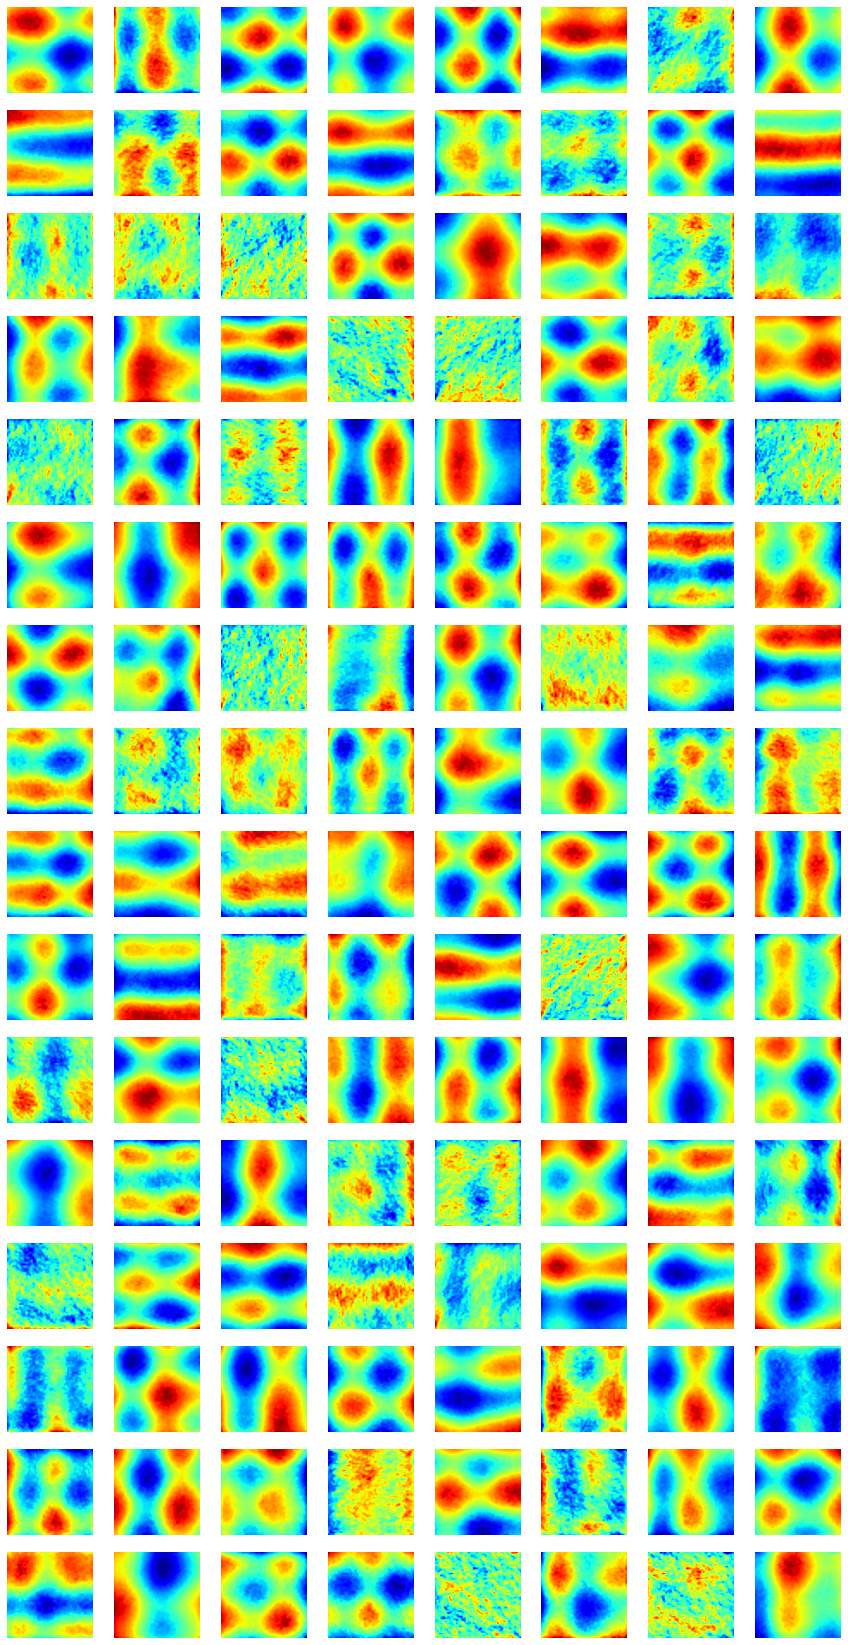

In [24]:
n_plot = 128

plt.figure(figsize=(15, int(30 * n_plot / 128)))
for i in range(n_plot):
    plt.subplot(n_plot//8, 8, 1 + i)
    plt.imshow(activations[i,:,:], interpolation="gaussian", cmap="jet")
    plt.axis('off')    
plt.show()